## Introduction

In this notebook we will take the simulation output for the MIRI LRS Time Series Observation, and run it through the pipeline, end to end. It is important to match the pipeline version to the version of MIRISim, to ensure the data products and reference files are maximally comptible. 

For MIRISim 2.4.0, the matching JWST pipeline version is 1.1.0 (Build 7.7). The JWST pipeline installation isntructions (including instructions for specific versions) can be found [here](https://github.com/spacetelescope/jwst/). The MIRISim installation comes packaged with the compatibel pipeline version, so you should be able to run this notebook in the same environment as used to run the simulations. 

At the time of writing, we have not yet fully tested and verified the Stage 3 pipeline (``Tso3Pipeline()``), so this notebook stops at the end of the 2nd pipeline stage, ``Spec2Pipeline()``. The main product that is **not** available from Stages 1 and 2 is the white light curve of the time series. 



In [7]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import matplotlib.pyplot as plt
import astropy.io.fits as fits

import jwst
from jwst.pipeline import Detector1Pipeline, Tso3Pipeline, Spec2Pipeline
from jwst.pipeline.collect_pipeline_cfgs import collect_pipeline_cfgs
from jwst.associations.asn_from_list import asn_from_list
import jwst.datamodels as datamodels


## Step 0: Some housekeeping

In this first step we:

* set up the input and output folders. you can amend these to your own preferred file structure
* locate and set up some ancillary files
* make a minor modification to the simulated data to ensure it is fully pipeline-compatible.

In [8]:
data_dir = 'mirilrs-tso-public_sim_v2.4.0/det_images/'
pipe_out = 'pipeline_output_{0}/'.format(jwst.__version__)

We need a special reference file for read noise subtraction when using MIRISim data. Let's locate it. We also need to set the cosmic ray detection threshold higher than in flight. 

In [9]:
readnoise = 'jwst_mirisim_readnoise.fits'
rej_thresh = 10.

We need to collect the pipeline configuration files, it's useful to have these collected locally. **Note**: the format of these files will be changing in the course of 2021 so some modifications of this step may be required. 

In [10]:
if not os.path.exists('../cfg_files/'):
    os.mkdir('../cfg_files/')
    cfgs = collect_pipeline_cfgs(dst='../cfg_files/')

Finally we need to add a header keyword to the simulation output file to mark it as a TSO.

In [11]:
uncal_file = glob.glob(data_dir+'*.fits')
print(uncal_file)


assert len(uncal_file) == 1, "Too many simulation files found, please check data directory"

hdu = fits.open(uncal_file[0], mode='update')
h = hdu[0].header
h['TSOVISIT'] = True
hdu.flush()

['mirilrs-tso-public_sim_v2.4.0/det_images/mirilrs_tso_MIRIMAGE_P750Lexp1.fits']


## Pipeline stage 1: Ramps to Slopes

Stage 1 of the JWST pipeline applies basic detector calibrations and converts the ramps into slope measurements. A dedicated configuration file should be used for TSOs to ensure that the correct sequence of steps is executed. 

For more information on the Detector1Pipeline, [see here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html#calwebb-detector1). 

In [17]:
# quick check that the TSOVISIT was set correctly!
mod = datamodels.open(uncal_file[0])
assert mod.meta.visit.tsovisit == True, "Data is not marked as TSO"

2021-05-20 16:29:12,447 - stpipe - WARNING - /Users/kendrew/anaconda3/envs/miricle/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



In [14]:
det1 = Detector1Pipeline.call(uncal_file[0], 
                              config_file='../cfg_files/calwebb_tso1.cfg', 
                              output_dir=pipe_out, 
                              steps={"jump": {"rejection_threshold" : rej_thresh, "override_readnoise": readnoise}, 
                                                          "ramp_fit": {"override_readnoise": readnoise}, 
                                                          "refpix":{"skip": True}}, 
                              save_results=True)


2021-05-20 16:09:50,163 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_pars-detector1pipeline_0002.asdf
2021-05-20 16:09:50,182 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-05-20 16:09:50,183 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-05-20 16:09:50,185 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-05-20 16:09:50,186 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-05-20 16:09:50,188 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-05-20 16:09:50,190 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-05-20 16:09:50,192 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-05-20 16:09:50,194 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2021-05-20 16:09:50,196 - stpipe.Detector1Pi

2021-05-20 16:09:50,773 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2021-05-20 16:09:50,774 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/Users/kendrew/miri/miri_datasims/TSO-MIRI-simulations/TSO-lrs-sims/lrs-tso-public/jwst_mirisim_readnoise.fits'.
2021-05-20 16:09:50,775 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_reset_0043.fits'.
2021-05-20 16:09:50,776 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits'.
2021-05-20 16:09:50,777 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits'.
2021-05-20 16:09:50,778 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2021-05-20 16:09:50,779 - stpipe.Detector1

2021-05-20 16:09:57,284 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2021-05-20 16:09:57,391 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(20, 100, 416, 72) from mirilrs_tso_MIRIMAGE_P750Lexp1.fits>,).
2021-05-20 16:09:57,393 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'mirilrs-tso-public_sim_v2.4.0/det_images', 'type': 'baseline'}
2021-05-20 16:09:57,415 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits
2021-05-20 16:09:57,716 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2021-05-20 16:09:57,824 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current runn

2021-05-20 16:10:02,326 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 32 pixels with at least one CR
2021-05-20 16:10:02,347 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 18:
2021-05-20 16:10:02,456 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 19 pixels with at least one CR
2021-05-20 16:10:02,475 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 19:
2021-05-20 16:10:02,585 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31 pixels with at least one CR
2021-05-20 16:10:02,605 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 20:
2021-05-20 16:10:02,709 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 9 pixels with at least one CR
2021-05-20 16:10:02,752 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 3.33116 sec
2021-05-20 16:10:02,754 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds:

## Pipeline stage 2: Slopes to Calibrated Images and Spectra

In the 2nd pipeline stage, we apply the necessary calibrations to the slope images to obtain spectrophotometrically calibrated images, as well as extracted spectra. We use the \_rateints.fits file as input, which has a slope image per integration, and as the data are flagged as a TSO the processing will be applied to each integration separately. 

In [18]:
ri_file = glob.glob(pipe_out+'*_rateints.fits')

assert len(ri_file) == 1, "Unexpected number of files found, please check your pipeline output directory"

sp2 = Spec2Pipeline.call(ri_file[0], config_file='../cfg_files/calwebb_tso-spec2.cfg', 
                         output_dir=pipe_out, save_results=True)



2021-05-20 16:30:10,133 - stpipe - WARNING - /Users/kendrew/anaconda3/envs/miricle/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

2021-05-20 16:30:10,376 - CRDS - INFO -  Fetching  /Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_pars-spec2pipeline_0001.asdf    2.0 K bytes  (1 / 1 files) (0 / 2.0 K bytes)
2021-05-20 16:30:11,469 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_pars-spec2pipeline_0001.asdf
2021-05-20 16:30:11,495 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-05-20 16:30:11,497 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-05-20 16:30:11,499 - stpip

2021-05-20 16:30:12,024 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'mirilrs_tso_MIRIMAGE_P750Lexp1_rateints.fits' reftypes = ['apcorr', 'area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2021-05-20 16:30:12,035 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_apcorr_0007.fits'.
2021-05-20 16:30:12,037 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2021-05-20 16:30:12,038 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2021-05-20 16:30:12,040 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2021-05-20 16:30:12,041 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A

2021-05-20 16:30:13,747 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2021-05-20 16:30:13,748 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2021-05-20 16:30:13,943 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<CubeModel(20, 416, 72) from mirilrs_tso_MIRIMAGE_P750Lexp1_rateints.fits>,).
2021-05-20 16:30:13,945 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'pipeline_output_1.1.0'}
2021-05-20 16:30:13,957 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_LRS-SLITLESS
2021-05-20 16:30:13,958 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None
2021-05-20 16:30:13,959 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in inp

2021-05-20 16:30:15,886 - stpipe.Spec2Pipeline.extract_1d - INFO - Beginning loop over 20 integrations ...
2021-05-20 16:30:15,902 - stpipe.Spec2Pipeline.extract_1d - INFO - Using extraction limits: 
2021-05-20 16:30:15,902 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=32.5, xstop=42.5, ystart=7, ystop=397
2021-05-20 16:30:15,906 - stpipe.Spec2Pipeline.extract_1d - WARNING - /Users/kendrew/anaconda3/envs/miricle/lib/python3.8/site-packages/jwst/extract_1d/extract.py:1895: RuntimeWarning: Mean of empty slice
  wavelength = np.nanmean(wl[sy0:sy1, sx0:sx1], axis=1)

2021-05-20 16:30:15,931 - stpipe.Spec2Pipeline.extract_1d - INFO - Output arrays have been trimmed by 4 elements
2021-05-20 16:30:15,949 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2021-05-20 16:30:16,161 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2021-05-20 16:30:16,365 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2021-05-20 16:30:16,57

Let's look at the spectra! The output of the Spec2Pipeline is the 2D calibrated image, so we need to locate and read in the extracted spectra file, which has extension \_x1dints.fits. 

2021-05-20 16:41:46,394 - stpipe - WARNING - /Users/kendrew/anaconda3/envs/miricle/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



<MultiSpecModel from mirilrs_tso_MIRIMAGE_P750Lexp1_x1dints.fits>


Text(0, 0.5, 'Jy')

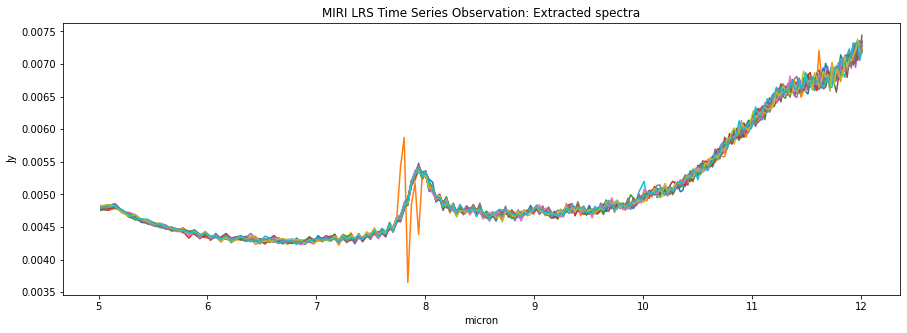

In [30]:
x1d = glob.glob(pipe_out+'*_x1dints.fits')

fig, ax = plt.subplots(1,1, figsize=[15,5])

nints = sp2[0].meta.exposure.nints

sp1d = datamodels.open(x1d[0])
print(sp1d)

for i in range(nints):
    plt.plot(sp1d.spec[i].spec_table['WAVELENGTH'], sp1d.spec[i].spec_table['FLUX'])

plt.title('MIRI LRS Time Series Observation: Extracted spectra')
plt.xlabel('micron')
plt.ylabel('Jy')

-- END
S. Kendrew, MIRI Instrument & Calibration Scientist, ESA/STScI, May 2021